<a href="https://colab.research.google.com/github/CataAlamos/Diagnostico-Capstone-S4/blob/main/RedesNeuronales.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Ejemplo de Uso de Redes Neuronales

En estos ejemplos se muestra cómo hacer una red neuornal desde cero y cómo entrenarla





# Setup inicial



## Setup de librerías
Liberías necesarias para que funcione el algoritmo.

In [ ]:
import numpy as np
import pandas as pd
from tqdm import tqdm
from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score


## Carga de base de datos

En estos ejemplos usaremos la base de datos de números en imágenes binarias




In [ ]:
#Descargar archivo
!wget -O oneline.txt https://www.dropbox.com/s/ps958u765f2jabe/oneline.txt

#Open, readlines, close
r = open("oneline.txt")
ls = r.readlines()
r.close()

n_nums = int(ls.pop(0).strip())
n_fils = int(ls.pop(0).strip())
n_cols = int(ls.pop(0).strip())

data = []
labels = []
for n in tqdm(range(0,n_nums)):
    #Numero correcto en string
    sres = [int(ls.pop(0).strip())]
    #Dibujo del numero en string
    sdat = [int(i) for i in ls.pop(0).strip()]
    data.append(sdat)
    labels.append(sres)
data = np.array([np.array(lst) for lst in data])
labels = np.array([np.array(lst) for lst in labels])


In [ ]:
## Números de prueba
Y_test = labels[:100]
X_test = data[:100].T

## Números de entrenamiento
Y_train = labels[100:]
X_train = data[100:].T
_,m_train = X_train.shape


In [ ]:
## Cantidad de datos de entrenamiento
X_train.shape

# Redes Neuronales

###En este ejemplo usaremos una red neuronal de input un vector de 786 elementos y ouput un vector de 10 elementos, con una capa oculta de 40 nodos.

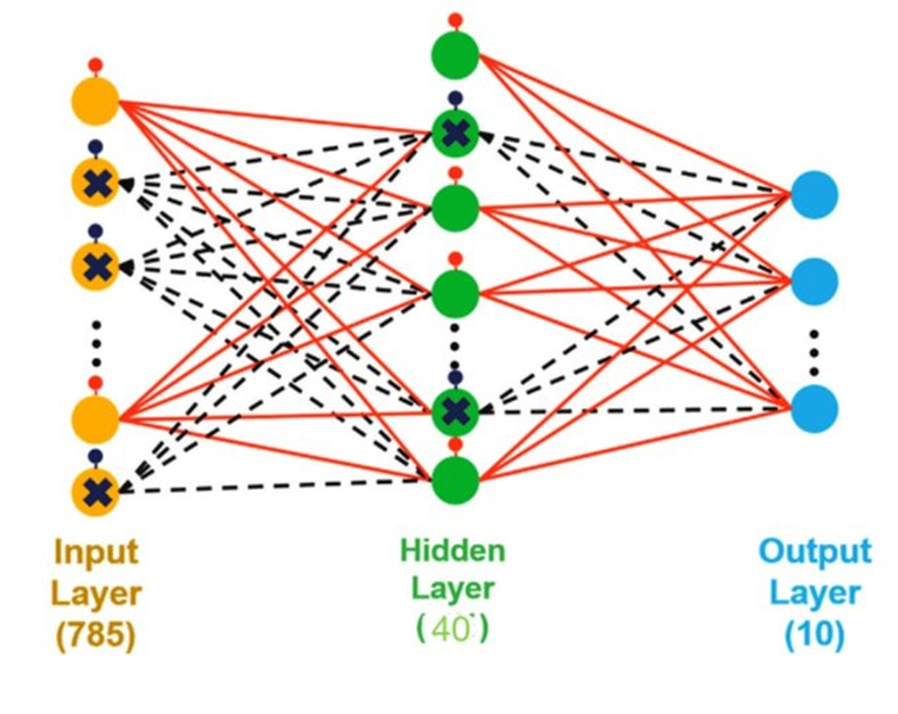

## Funciones a utilizar:

### 1.   **nn_definition**:
Definición de las capas de la red neuronal, creando la matriz de los pesos y sesgos de cada una de los nodos.

### 2.   **nn_forward_propagation**:
Método de ingreso del input y aplicación de las distintas multiplicaciones a través de los nodos de la red para obtener el vector resultante.

### 3.  **nn_backward_propagation**:
Calculo de los ajustes de los pesos y sesgos en base al error de las predicciones.

### 4. **nn_parameters_update**:
Actualización de los pesos y sesgos de la red.

### 5. **Conversión de etiquetas**: clases <-> vetores

**yclass** : vector nx1 con m classes

**yhot**   : matris mxn donde yhot(i,j)=c si y(j)==i

In [ ]:
def nn_definition(n):
    W  = [None]
    b  = [None]
    m1 = len(n)
    for k in range(1,m1):
      temp = [np.random.rand(n[k],n[k-1]) - 0.5] # números al azar
      W    = W  + temp
      temps = [np.random.rand(n[k],1)- 0.5] # números al azar
      b    = b  + temps
    return W,b


def nn_forward_propagation(X,W,b):
    a = [None]
    a[0]  = X
    m1 = len(W)
    for k in range(1,m1):
        zk = W[k].dot(a[k-1])+b[k]
        a = a + [1/(1+np.exp(-zk))]

    return a

def nn_backward_propagation(Y,a,W,b):
    m = len(W)-1
    N = Y.shape[1]
    dam = a[m]-Y
    dW = [None]
    db = [None]

    # Derivatives
    for k in range(1,m+1):
        dW   = dW + [np.zeros([W[k].shape[0],W[k].shape[1]])]
        db   = db + [np.zeros([b[k].shape[0],1])]

    for k in range(m,0,-1):
        if k == m:
            dak = dam
        ds    = np.multiply(a[k], 1-a[k])
        Gk    = np.multiply(dak,ds)
        dW[k] = 1/N*np.matmul(Gk,a[k-1].transpose())
        db[k] = 1/N*(np.sum(Gk,axis=1,keepdims=True))
        dak   = np.matmul(W[k].transpose(),Gk)

    return dW,db

def nn_parameters_update(W,b,dW,db,alpha):
    m1 = len(W)

    # Updates
    for k in range(1,m1):
        b[k] = b[k] - alpha*db[k]
        W[k] = W[k] - alpha*dW[k]

    return W,b

def class2hot(yclass):
  ymin = (np.min(yclass)).astype(int)
  ymax = (np.max(yclass)).astype(int)
  y = (yclass - ymin).astype(int)
  m = ymax-ymin+1
  n = y.shape[0]
  yhot = np.zeros((m,n))
  for i in range(n):
    yhot[y[i],i] = 1
  return yhot

def hot2class(yhot):
  yclass  = np.argmax(yhot,axis = 0)
  return yclass

## Entrenamiento

In [ ]:
def fit_model(learning_rate = 1, epocs= 100, hidden_layers=[40], silent = False):
    # Conversión de datos a hotencoding
    Ytrain      = class2hot(Y_train)

    # Definiciones
    N           = X_train.shape[1]                 # Números de entrenamiento
    n_0         = X_train.shape[0]                 # Tamaño de entrada (X)
    n_m         = Ytrain.shape[0]                  # Tamaño de salida (Y)
    n           = [n_0] + hidden_layers + [n_m]    # Nodos por cada capa
    m           = len(n)-1

    if not silent:
        print(f"Capas de la red {n}")

    # Entrenamiento
    t     = 0
    train =  True
    W,b   = nn_definition(n)                                       # (Paso 1) Definición de las cápaz de la red

    while train:
        t         = t + 1
        a         = nn_forward_propagation(X_train,W,b)            # (Paso 2)
        dW,db     = nn_backward_propagation(Ytrain,a,W,b)          # (Paso 3)
        W,b       = nn_parameters_update(W,b,dW,db,learning_rate)  # (Paso 4) Actualización de los pesos y sesgos

        if t % 10 == 0:
            a = nn_forward_propagation(X_train,W,b)                  # El vector de salida es a[m]
            y0 = hot2class(a[m])
            acc = accuracy_score(Y_train,y0)
            if not silent:
                print(f"Iteration: {t}")
                print(f"Acc: {acc * 100:.2f}%")


        train =  t < epocs



    return W, b, acc

In [ ]:
W, b, acc = fit_model(4, 200, [40], False)

### Experimento opcional
Si quieren buscar el modelo más ptimo para predecir números, puede correr esta iteración de variaciones de parametros de entrenamiento para encontrarlo.


In [ ]:
#### Opcional ####
# W, b, acc = None, None, 0

# for lr in range(1, 10, 1):
#     for epoc in range(100, 500, 50):
#         new_W, new_b, new_acc = fit_model(learning_rate=lr, epocs=epoc, hidden_layers=[40], silent=False)
#         if new_acc > acc:
#             W = new_W
#             b = new_b
#             acc = new_acc
#             print(f"Learning Rate: {lr}, Epoc: {epoc}, Acc: {acc * 100:.2f}%")

## Testeo

In [ ]:
def get_predictions(A):
    return np.argmax(A, 0)

def make_predictions(X, W, b, weights = False):
    a = nn_forward_propagation(X,W,b)
    predictions = get_predictions(a[-1])

    if weights:
        return predictions, a[-1]
    return predictions

def test_prediction(index, W, b):
    current_image = X_test[:, index, None]
    prediction = make_predictions(X_test[:, index, None], W, b)
    label = Y_test[index]
    print("Prediction: ", prediction)
    print("Label: ", label)

    current_image = current_image.reshape((28, 28)) * 255
    plt.gray()
    plt.imshow(current_image, interpolation='nearest')
    plt.show()

def predict(text, silent=False):
    text_int = [int(i) for i in text]
    number = np.array([text_int]).T
    prediction, weights = make_predictions(number, W, b, True)
    print(f"Predicción: {prediction[0]}")
    print("Pesos: ")

    if not silent:
        for index, w in enumerate(weights):
            print(f"{index}: {w[0]:.2f}")
        plt.figure(figsize=(2, 2))
        plt.imshow(np.array(text_int).reshape((28, 28)), cmap='gray', interpolation='nearest')
        plt.show()

In [ ]:
preds = make_predictions(X_test, W, b_2)
accuracy_score(preds, Y_test)

In [ ]:
test_prediction(0, W, b)
test_prediction(1, W, b)
test_prediction(2, W, b)
test_prediction(3, W, b)
test_prediction(4, W, b)

### Predicción

prueba con tus propios números que puedes crear en: [textTo01](https://textto01.vercel.app/)

OJO: crea tus números del mayor tamaño posible, y ocupa el botón copiar linea.

In [ ]:
predict()

In [ ]:
predict()

In [ ]:
predict()